In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# !pip install jupyterlab ipywidgets

In [18]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import glob
from bs4 import BeautifulSoup
import datetime
import re

In [19]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [20]:
tweets_path = '/content/drive/My Drive/database/Tweets/bitcoin/'
bitcoin_file = '/content/drive/My Drive/database/bitcoinHistoricalData/bitcoin.csv'
crypto_name = 'bitcoin'

In [21]:
# initializing dataframes
df_noOfTweets = pd.DataFrame(columns=['date','positive', 'neutral', 'negative', 'total']) # for the barchart of no. of tweets
df_polarity_line = pd.DataFrame(columns=['date','polarity']) # for the polarity line chart

# Tweets about each crypto is taken from saved txt files with dates ranging from 2017-09-01 to 2017-11-30
# Tweets are collected by selenium automated script written in python
for f in glob.glob( str(tweets_path) + crypto_name + '*.txt'):
    df_datawise = pd.read_csv(f, sep='\t', encoding='utf-8', parse_dates=True)
    polarity = 0.00
    neutral = positive = negative = 0
    for idx,row in df_datawise.iterrows():
        polarity += float(row["polarity"])
        
        # adding reaction of how people are reacting to find average later
        if (float(row["polarity"]) >= -0.1 and float(row["polarity"]) <= 0.1):  
            neutral += 1
        elif (float(row["polarity"]) > 0.1):
            positive += 1
        elif (float(row["polarity"]) <-0.1):
            negative += 1
    positive = percentage(positive, len(df_datawise.index))
    negative = percentage(negative, len(df_datawise.index))
    neutral = percentage(neutral, len(df_datawise.index))
    # below df format is for barchart with sentiments
    df_temp_df_noOfTweets = pd.DataFrame({'date': df_datawise.iloc[0]['date'], 'positive': ((positive/100)*len(df_datawise.index)),'neutral': ((neutral/100)*len(df_datawise.index)), 'negative': ((negative/100)*len(df_datawise.index)), 'total': len(df_datawise.index)}, index=[0])
    # print(df_temp_df_noOfTweets)
    # polarity /= df_temp_df_noOfTweets['total']
    df_noOfTweets = df_noOfTweets.append(df_temp_df_noOfTweets,sort=True, ignore_index=True)
    
    # below df format is for polarity_line with sentiments
    df_temp_polarity_line = pd.DataFrame({'date': df_datawise.iloc[0]['date'], 'polarity': polarity}, index=[0])
    df_polarity_line = df_polarity_line.append(df_temp_polarity_line, sort=True, ignore_index=True)

df_noOfTweets = df_noOfTweets.sort_values(by = 'date')
df_noOfTweets.reset_index(inplace=True)
required_tweets = ['date','positive','neutral','negative','total']
df_noOfTweets = df_noOfTweets[required_tweets]

df_polarity_line = df_polarity_line.sort_values(by = 'date')
df_polarity_line.reset_index(inplace=True)
required_polarity = ['date','polarity']
df_polarity_line = df_polarity_line[required_polarity]

In [22]:
print(df_polarity_line.shape)    
print(len(df_polarity_line)) 

(91, 2)
91


In [23]:
prediction_days = 15
req = ['polarity']
df_polarity_line = df_polarity_line[req]
df_train= df_polarity_line[:len(df_polarity_line) - prediction_days] 
df_test= df_polarity_line[len(df_polarity_line)-prediction_days:]

training_set = df_train.values
print(training_set)
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))

[[ 44.84127886]
 [ 34.72393849]
 [ 30.12381043]
 [ 43.90672063]
 [ 51.60989305]
 [ 49.39670815]
 [ 54.01774788]
 [ 45.23649802]
 [ 36.86736263]
 [ 43.62673601]
 [ 45.28123467]
 [ 38.1382328 ]
 [ 56.79393598]
 [ 56.14570337]
 [ 59.89907314]
 [  9.88315446]
 [ 49.61875174]
 [ 49.05703698]
 [ 49.64881631]
 [ 44.84952994]
 [ 36.79902312]
 [ 46.76261011]
 [ 37.00751834]
 [ 40.71855783]
 [ 47.90088936]
 [ 44.59732928]
 [ 50.33652718]
 [ 46.36906472]
 [ 54.04768669]
 [ 33.32747926]
 [ 47.538048  ]
 [ 53.30367176]
 [ 44.61395399]
 [ 46.99523922]
 [ 52.85774779]
 [ 49.65176776]
 [ 39.23327325]
 [ 45.06565479]
 [ 64.45839601]
 [ 64.05344494]
 [ 49.02993597]
 [ 69.14563293]
 [ 67.38291578]
 [ 40.39778633]
 [ 42.93939138]
 [ 61.87198007]
 [ 57.58585678]
 [ 61.17085683]
 [ 64.90318092]
 [ 61.83325431]
 [ 62.98058411]
 [ 41.22259751]
 [ 57.81689296]
 [ 70.14401393]
 [ 68.57515347]
 [ 65.96972327]
 [ 53.58439078]
 [ 40.44496268]
 [ 48.92850454]
 [ 62.66725361]
 [ 76.58504479]
 [ 68.94123828]
 [ 66.62

In [24]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1)) # changed here
training_set = sc.fit_transform(training_set)
inputs = sc.fit_transform(inputs)

X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

X_train = np.reshape(X_train, (len(X_train), 1, 1))
inputs = np.reshape(inputs, (len(inputs), 1, 1))

In [10]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer (4 LSTM blocks or neurons).
# Default sigmoid activation function is used for the LSTM blocks.
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape=(1, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 4)

Epoch 1/4
15/15 [==============================] - 0s 1ms/step - loss: 0.8911
Epoch 2/4
15/15 [==============================] - 0s 1ms/step - loss: 0.8247
Epoch 3/4
15/15 [==============================] - 0s 1ms/step - loss: 0.7630
Epoch 4/4
15/15 [==============================] - 0s 1ms/step - loss: 0.7060


In [25]:
predicted_polarity = regressor.predict(inputs)
predicted_polarity = sc.inverse_transform(predicted_polarity)
dataframe = pd.DataFrame.from_records(predicted_polarity)
print(dataframe)
dataframe.columns = ['Predicted_Polarity']

            0
0   28.135138
1   28.331886
2   26.263968
3   26.497793
4   24.950741
5   27.413074
6   29.591003
7   27.260651
8   27.520458
9   26.123434
10  28.759674
11  32.157257
12  31.257305
13  35.698135
14  30.505526
            0
0   28.135138
1   28.331886
2   26.263968
3   26.497793
4   24.950741
5   27.413074
6   29.591003
7   27.260651
8   27.520458
9   26.123434
10  28.759674
11  32.157257
12  31.257305
13  35.698135
14  30.505526


In [26]:
data = pd.read_csv(bitcoin_file)
req_features = ['Timestamp','Close']
df_bitcoin = pd.DataFrame(columns=['date','close'])
frequency=0
sum=0
cur_date=""
for index in data.index:
  date = data['Timestamp'][index]
  date = date.split(' ')[0]
  value = float(data['Close'][index])
  if date != cur_date:
    if cur_date != "":
      sum = sum/frequency
      temp = pd.DataFrame({"date":[cur_date], "close":[sum]}) 
      df_bitcoin = df_bitcoin.append(temp, ignore_index = True)
    cur_date = date
    frequency = 1
    sum = value
  else:
    sum += value
    frequency += 1  
sum = sum/frequency
temp = pd.DataFrame({"date":[cur_date], "close":[sum]}) 
df_bitcoin = df_bitcoin.append(temp, ignore_index = True)
print(df_bitcoin)

           date         close
0    2017-01-01    972.979660
1    2017-01-02   1009.515215
2    2017-01-03   1016.678812
3    2017-01-04   1061.083632
4    2017-01-05   1087.840451
..          ...           ...
360  2017-12-27  15823.691576
361  2017-12-28  14551.233222
362  2017-12-29  14428.807889
363  2017-12-30  13898.596042
364  2017-12-31  13197.474549

[365 rows x 2 columns]
           date         close
0    2017-01-01    972.979660
1    2017-01-02   1009.515215
2    2017-01-03   1016.678812
3    2017-01-04   1061.083632
4    2017-01-05   1087.840451
..          ...           ...
360  2017-12-27  15823.691576
361  2017-12-28  14551.233222
362  2017-12-29  14428.807889
363  2017-12-30  13898.596042
364  2017-12-31  13197.474549

[365 rows x 2 columns]


In [30]:
df_bitcoin1 = df_bitcoin[len(df_bitcoin)-46:]
df_bitcoin2 = df_bitcoin1[:15]

df_bitcoin2.reset_index(inplace=True)
# print(df_bitcoin2)
req = ['date','close']
df_bitcoin3 = df_bitcoin2[req]
# print(df_bitcoin3)
# print(dataframe)
dataframe1 = pd.concat([df_bitcoin3, dataframe.reindex(df_bitcoin3.index)], axis=1)
print(dataframe1)

          date         close  Predicted_Polarity
0   2017-11-16   7334.280826           28.135138
1   2017-11-17   7844.846618           28.331886
2   2017-11-18   7708.000882           26.263968
3   2017-11-19   7783.521396           26.497793
4   2017-11-20   8077.297201           24.950741
5   2017-11-21   8202.975861           27.413074
6   2017-11-22   8201.752792           29.591003
7   2017-11-23   8202.604819           27.260651
8   2017-11-24   8164.645583           27.520458
9   2017-11-25   8390.028278           26.123434
10  2017-11-26   8988.064681           28.759674
11  2017-11-27   9619.731590           32.157257
12  2017-11-28   9822.075715           31.257305
13  2017-11-29  10484.614472           35.698135
14  2017-11-30  10047.583646           30.505526


In [29]:
import plotly.graph_objs as go
from plotly.offline import *
import plotly

trace1 = go.Scatter(
    x=dataframe1['date'],
    y=dataframe1['Predicted_Polarity'],
    mode = 'lines',
    name='Predicted polarity'
)

#total number of tweets in dataset
# print(df_noOfTweets['total'].sum())

trace2 = go.Scatter(
    x=dataframe1['date'],
    y=dataframe1['close'],
    mode = 'lines',
    name='Bitcoin price',
    yaxis='y2'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Sentiment Polarity Vs. Closing Price (in USD)',
    yaxis=dict(
        title='Predicted polarity'
    ),
    yaxis2=dict(
        title='Closing Price',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='No_Of_Tweets.html') # Plot No. of Tweets


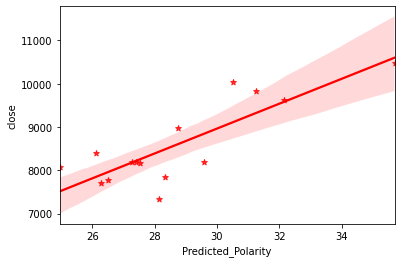

In [31]:
# Regression in polarity vs closing price
import seaborn as sns
import matplotlib as plt
sns.regplot(x=dataframe1['Predicted_Polarity'], y=dataframe1['close'], color='red', marker='*')

In [32]:
# Calculating the Pearson coefficient
from scipy import stats
pearson_coef, p_value = stats.pearsonr(dataframe1['Predicted_Polarity'], dataframe1['close'])
print(pearson_coef)

0.8317188691680245
